In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Example'
! ls

/content/gdrive/MyDrive/Example
10_Fine_tuning_VGG16.ipynb     6_Cifar10_VGG16.ipynb
1_MLP_Fashion_MNIST.ipynb      7_Custom_dataset_VGG16.ipynb
2_MLP_Cifar10.ipynb	       8_Chest_Xray.ipynb
3_Classification_Models.ipynb  9_Feature_extractor_VGG16.ipynb
4_LeNet.ipynb		       chest_xray.zip
5_VGG16.ipynb		       Dataset


In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
train_path = '/content/gdrive/MyDrive/Example/Dataset/train'
valid_path = '/content/gdrive/MyDrive/Example/Dataset/valid'
test_path = '/content/gdrive/MyDrive/Example/Dataset/test'

## Data Generator

In [5]:
batch_size = 32
img_size = 224

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 32 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            shuffle = False,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


### Model Definition and Hyperparameter Settings

In [6]:
vgg16 = VGG16(input_shape = (img_size,img_size,3), weights='imagenet', include_top=False)

vgg16.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg16.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:fine_tune_at]:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg16.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step
Number of layers in the base model:  19


### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 5 successive epochs
- Stop the training if the validation loss does not decrease after 10 successive epochs
- Save the best model if it has a better validation loss than before

In [7]:
model_name = "/content/gdrive/MyDrive/Example/model.h5"

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 10, 
                              verbose = 1, 
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0000001)

### Model Training

In [8]:
history = model.fit(training_set,
                    epochs=50,
                    validation_data=valid_set,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 2.6028 - accuracy: 0.3583 
Epoch 1: val_loss improved from inf to 1.07793, saving model to /content/gdrive/MyDrive/Example/model.h5
8/8 [==============================] - 154s 17s/step - loss: 2.6028 - accuracy: 0.3583 - val_loss: 1.0779 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.3833
Epoch 2: val_loss improved from 1.07793 to 0.68507, saving model to /content/gdrive/MyDrive/Example/model.h5
8/8 [==============================] - 4s 483ms/step - loss: 1.0982 - accuracy: 0.3833 - val_loss: 0.6851 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.8220 - accuracy: 0.6417
Epoch 3: val_loss improved from 0.68507 to 0.29762, saving model to /content/gdrive/MyDrive/Example/model.h5
8/8 [==============================] - 4s 469ms/step - loss: 0.8220 - accuracy: 0.6417 - val_loss: 0.2976 - val_accu

In [9]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0016
Test accuracy: 1.0000


### Learning Curves

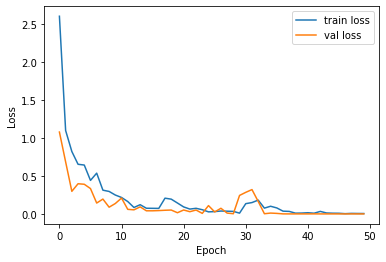

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig(root_path + 'loss curve', dpi=3000)

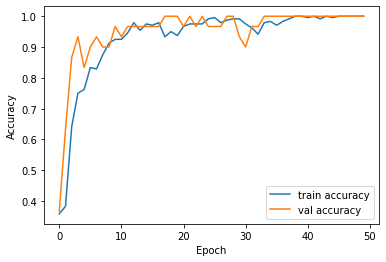

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#fig.savefig(root_path + 'accuracy curve', dpi=3000)

**Confusion matrix**

1/1 [==============================] - 0s 236ms/step


<Figure size 432x288 with 0 Axes>

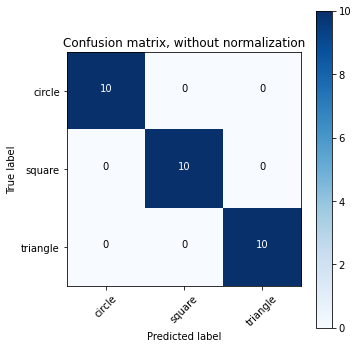

<Figure size 432x288 with 0 Axes>

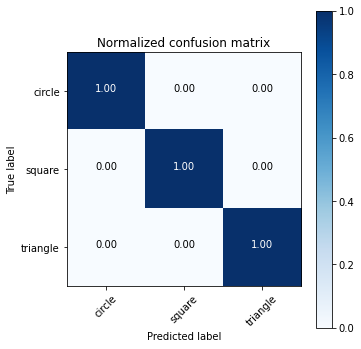

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

Y_pred = model.predict(test_set, verbose=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true = test_set.classes, y_pred = np.argmax(Y_pred, axis = -1))
class_names = ['circle', 'square', 'triangle']
      
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**ROC curve**

1/1 [==============================] - 0s 109ms/step


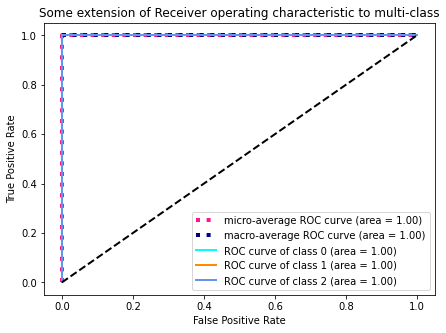

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

true_classes = test_set.classes
y_true1 = label_binarize(true_classes,classes=[0,1,2])    
predictions = model.predict(test_set, verbose=1)

fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
n_classes = y_true1.shape[1]
for k in range(n_classes):
    fpr[k], tpr[k], thresholds[k] = roc_curve(y_true1[:,k], predictions[:,k], drop_intermediate=False)
    roc_auc[k] = auc(fpr[k], tpr[k])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true1.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
   
all_fpr = np.unique(np.concatenate([fpr[k] for k in range(n_classes)]))
    
mean_tpr = np.zeros_like(all_fpr)
for k in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for k, color in zip(range(n_classes), colors):
    plt.plot(fpr[k], tpr[k], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(k, roc_auc[k]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Model Evalutation

In [14]:
from sklearn.metrics import classification_report

In [15]:
y_test = test_set.classes
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred,axis=1)

1/1 [==============================] - 0s 91ms/step


In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

